# Subsets for stats in R
In this notebook I'm just selecting out only the columns we need to perform ANOVA and post hoc tests in R. That is, I only need our measurement (normalized intensity) and treatment/reactivation labels. 

In [1]:
import os
import numpy as np
import pandas as pd
import shutil

In [2]:
if os.path.exists('Rsubsets') and os.path.isdir('Rsubsets'):
    shutil.rmtree('Rsubsets')

os.mkdir('Rsubsets')
    
for f in os.listdir('NORM'):
    df = pd.read_csv(f'NORM/{f}')

    # rename some cols for convenience
    df = df.rename(columns={'treatment': 'treat', 'norm_adjusted_mean-background': 'norm_int'})

    # write to disk
    df[['treat', 'norm_int']].to_csv(f"Rsubsets/{f.replace('.csv', '_Rsubset.csv')}")

In [3]:
import shutil

if os.path.exists('NORM_MEANS') and os.path.isdir('NORM_MEANS'):
    shutil.rmtree('NORM_MEANS')

os.mkdir('NORM_MEANS')
for f in os.listdir('NORM'):
    df = pd.read_csv(f'NORM/{f}')

    df_means = df.groupby('rat_n')['norm_adjusted_mean-background'].mean().reset_index(name='mean_norm_intensity')
    df_merge = df[['rat_n', 'coloc_stain_type']].drop_duplicates().merge(df_means)
    df_merge['n0'], df_merge['n1'] = zip(*df_merge.rat_n.apply(lambda x: [int(y) for y in x.split('-')[1:]]))
    df_merge = df_merge.merge(df_merge.merge(df[['rat_n', 'treatment']].drop_duplicates()))
    df_merge = df_merge.sort_values(by=['treatment', 'n0', 'n1'])[['rat_n', 'treatment', 'coloc_stain_type', 'mean_norm_intensity']]

    f_means = f.replace('.csv', '_MEANS_BY_RAT.csv')

    df_merge.to_csv(f'NORM_MEANS/{f_means}')



In [4]:
df_merge

,rat_n,treatment,coloc_stain_type,mean_norm_intensity
1,KET-8-8,6mg/kg,single_PV,0.637707
4,KET-8-9,6mg/kg,single_PV,1.105377
0,KET-8-10,6mg/kg,single_PV,1.376127
5,KET-8-12,6mg/kg,single_PV,0.670251
2,KET-8-13,6mg/kg,single_PV,0.928042
3,KET-8-15,6mg/kg,single_PV,1.450841
6,KET-8-16,6mg/kg,single_PV,0.971365
8,KET-6-2,Saline,single_PV,0.874547
11,KET-6-3,Saline,single_PV,1.118378
9,KET-6-4,Saline,single_PV,1.122327


In [5]:
import shutil

def normalize_intensity(df, norm_condition, col='mean-background'):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm[col].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm[f'norm_{col}'] = df[col].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition][f'norm_{col}'].mean(), 5) == 1
    
    return df_norm

if os.path.exists('R_posthoc_subsets') and os.path.isdir('R_posthoc_subsets'):
    shutil.rmtree('R_posthoc_subsets')

os.mkdir('R_posthoc_subsets')
df = pd.read_csv('POST_VR5_FINAL.csv')

for stain in df.stain_type.unique():
    df_subset = df.query(f'stain_type == "{stain}"')[['stain_type', 'adjusted_mean-background', 'treatment', 'dummy_PV', 'dummy_WFA']]
    df_norm = normalize_intensity(df_subset.rename(columns={'adjusted_mean-background': 'intensity'}), norm_condition='Saline', col='intensity')
    df_norm.to_csv(f'R_posthoc_subsets/NORM_single_{stain}.csv')

<Axes: xlabel='dummy_PV', ylabel='norm_intensity'>

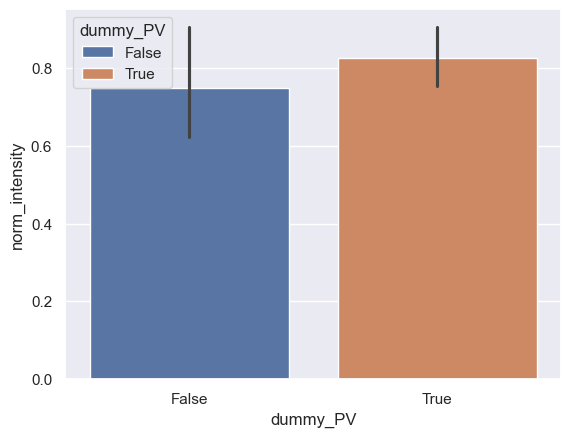

In [6]:
# let's just check that the normalized result comes out as we expect 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.barplot(y='norm_intensity',  x='dummy_PV', hue='dummy_PV', data=df_norm)